<a href="https://colab.research.google.com/github/marcociav/smile-app/blob/master/model-creation/model_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smile App - Model Creation

## Imports

### Packages

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers

from utils import normalize_img
from model import CycleGan, get_resnet_generator, get_discriminator

In [2]:
# check if everything is properly configured
print(f"GPU(s): {tf.config.list_physical_devices('GPU')}")
print(f"tensorflow version: {tf.__version__}")

GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tensorflow version: 2.7.0


### Images

In [3]:
smile_path = 'data/transformed/smile'
non_smile_path = 'data/transformed/non_smile'

### Set constants

In [4]:
# buffer_size = 256
epochs = 1000
batch_size = 16
w, h = 64, 64  # known by previously analizing images


## Create Image Datasets

### Train Test Split

In [5]:
smile_ds = image_dataset_from_directory(
    smile_path,
    labels=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(w, h),
    seed=42
)

non_smile_ds = image_dataset_from_directory(
    non_smile_path,
    labels=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(w, h),
    seed=42
)

Found 600 files belonging to 1 classes.
Found 603 files belonging to 1 classes.


In [6]:
smile_ds = smile_ds.map(normalize_img)
non_smile_ds = non_smile_ds.map(normalize_img)

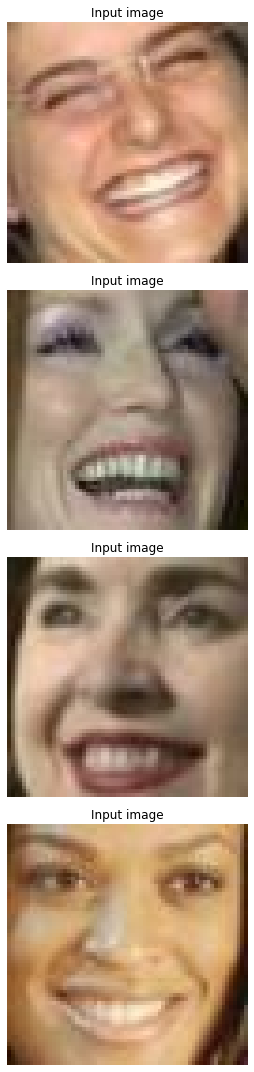

In [7]:
_, ax = plt.subplots(4, 1, figsize=(10, 15))
for i, img in enumerate(smile_ds.take(4)):
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i].imshow(img)
    ax[i].set_title("Input image")
    ax[i].set_title("Input image")
    ax[i].axis("off")

plt.tight_layout()
plt.show()

## Train CycleGAN

In [8]:
# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

In [9]:
gen_G.summary(), gen_F.summary(), disc_X.summary(), disc_Y.summary(), 

Model: "generator_G"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 generator_G_img_input (InputLa  [(None, 64, 64, 3)]  0          []                               
 yer)                                                                                             
                                                                                                  
 reflection_padding2d (Reflecti  (None, 70, 70, 3)   0           ['generator_G_img_input[0][0]']  
 onPadding2D)                                                                                     
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   9408        ['reflection_padding2d[0][0]']   
                                                                                        

(None, None, None, None)

In [10]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

In [11]:

# Callbacks
# plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

cycle_gan_model.fit(
    tf.data.Dataset.zip((non_smile_ds, smile_ds)),
    epochs=epochs,
    # callbacks=[model_checkpoint_callback],  # add plotter if necessary
)


Epoch 1/1000
38/38 [==============================] - 67s 536ms/step - G_loss: 5.0162 - F_loss: 5.0337 - D_X_loss: 0.2976 - D_Y_loss: 0.2987
Epoch 2/1000
38/38 [==============================] - 20s 512ms/step - G_loss: 3.4326 - F_loss: 3.5216 - D_X_loss: 0.1738 - D_Y_loss: 0.1703
Epoch 3/1000
38/38 [==============================] - 20s 516ms/step - G_loss: 3.1550 - F_loss: 3.2728 - D_X_loss: 0.2119 - D_Y_loss: 0.2187
Epoch 4/1000
38/38 [==============================] - 20s 522ms/step - G_loss: 3.2763 - F_loss: 3.3208 - D_X_loss: 0.1507 - D_Y_loss: 0.1655
Epoch 5/1000
38/38 [==============================] - 20s 530ms/step - G_loss: 3.2092 - F_loss: 3.3411 - D_X_loss: 0.1612 - D_Y_loss: 0.1840
Epoch 6/1000
38/38 [==============================] - 22s 564ms/step - G_loss: 3.0475 - F_loss: 3.1992 - D_X_loss: 0.1974 - D_Y_loss: 0.1998
Epoch 7/1000
38/38 [==============================] - 22s 585ms/step - G_loss: 3.0824 - F_loss: 3.2642 - D_X_loss: 0.1555 - D_Y_loss: 0.1800
Epoch 8/1000


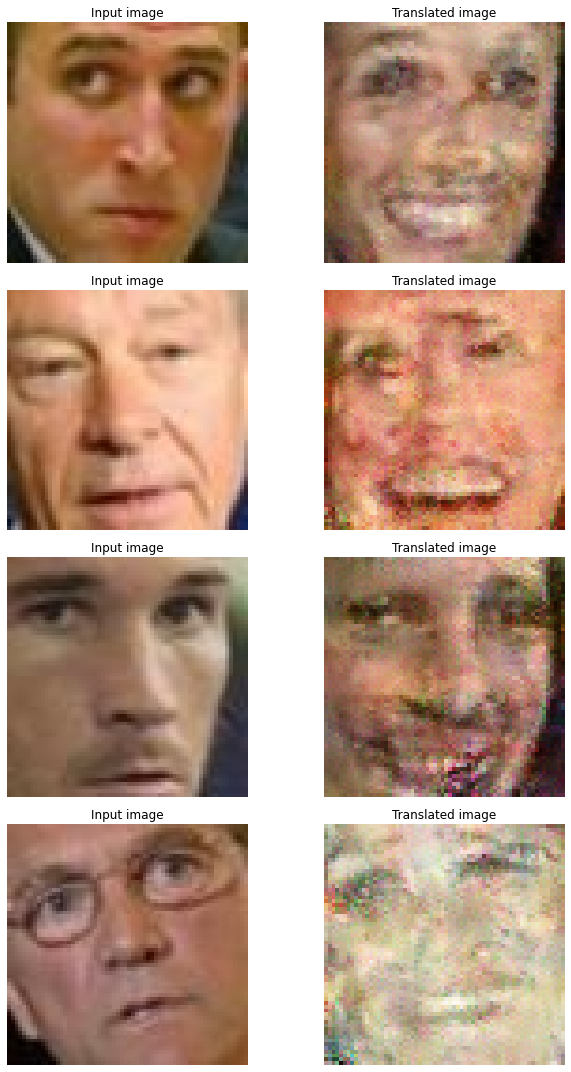

In [12]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(non_smile_ds.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    # prediction = keras.preprocessing.image.array_to_img(prediction)
    # prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()

In [13]:
save = True
if save:
  cycle_gan_model.gen_G.save('models/smile_app_model_v2')

INFO:tensorflow:Assets written to: models/smile_app_model_v2\assets


INFO:tensorflow:Assets written to: models/smile_app_model_v2\assets
c:\users\marco\projects\smile-app\model-creation\samc_venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\users\marco\projects\smile-app\model-creation\samc_venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
